In [2]:
import pandas as pd
import implicit
import numpy as np
from scipy import sparse, stats
import pickle
import gc

import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, precision_recall_curve, auc

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import time
import copy
import os


pd.options.display.max_columns = None
%matplotlib inline

params = {'axes.titlesize':'32',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14'}
matplotlib.rcParams.update(params)


Решается задача товарных рекомендаций.

- `purchases_train.csv` - история покупок в розничном магазине (с 21 октября 2003 года по 12 марта 2004 года)

- `purchases_test.csv` - покупки за следующую неделю (с 13 по 19 марта 2004 года). В этой выборке для каждого пользователя исключены товары, которые он уже покупал за период обучающей выборки

- `customers.csv` - пол клиентов

В решении ниже
- обучается модель матричного разложения AlternateLeastSquares
- сравнивается с тестовыми данными
- измеряется ее качество по метрике map@10
- данные о поле клиентов не используются

Улучшите решение с помощью информацию о поле клиентов

In [3]:
purchases_train = pd.read_csv('purchases_train.csv')
purchases_train.head()

,customer_id,product_id,datetime
0,8698595,12530,2004-03-10 22:18:43.497459200
1,13271885,7541,2004-03-06 02:24:43.209763200
2,16852746,13134,2004-03-10 01:03:09.598614400
3,16852746,6572,2004-03-04 16:45:16.522566400
4,14619070,4659,2004-03-12 13:29:35.011481600


Обучаем модель AlternateLeastSquares (Обучить baseline с числом факторов = 64 не получилось - переполнение по памяти, поэтому была обучена модель с числом факторов = 32)

In [4]:
class Als():
    def __init__(self, train, cond=None):
        if cond is None:
            cond = train.index
            
        self.user_items = sparse.coo_matrix(
            (
                np.ones(train.loc[cond].customer_id.size, dtype=np.float32),
                (
                    train.loc[cond].customer_id,
                    train.loc[cond].product_id
                )
            )
        ).tocsr()
        sparsity = 100 * (1 - train.loc[cond].drop_duplicates(['customer_id', 'product_id']).shape[0] / (train.loc[cond].customer_id.unique().shape[0] * train.loc[cond].product_id.unique().shape[0]))
        print('sparsity:', sparsity)
        self.item_users = self.user_items.T.tocsr()
        self.model = None
    
    def fit(self, params={'factors': 32, 'regularization': 0.1, 'iterations': 100}):
        self.model = implicit.als.AlternatingLeastSquares(**params)
        np.random.seed(42)
        print('Fit the model...')
        self.model.fit(item_users=self.item_users)
        
    def save_model(self, filename):
        print('Saving model...')
        if self.model is None:
            print('model is not defined and fitted')
            return
        with open(filename, 'wb') as f:
            pickle.dump(self.model, f)
        
    def load_model(self, filename):
        print('Loading model...')
        with open(filename, 'rb') as f:
            self.model = pickle.load(f)
    
    def recommend(self, user_id, k=10):
        if self.model is None:
            print('model is not defined and fitted')
            return
    
        return self.model.recommend(userid=user_id, user_items=self.user_items, N=k)

In [6]:
als = Als(purchases_train)

sparsity: 99.82308942476247


In [7]:
als.fit()

Fit the model...


In [ ]:
als.save_model('base_model.pickle')

In [7]:
als.load_model('base_model.pickle')

Loading model...


purchases_test.csv содержит данные о покупках с 13 марта 2004 по 20 марта 2004 - то есть неделя следующая за обучающей выборкой

для каждого пользователя исключены те товары, которые он покупал в обучающей выборке

In [5]:
purchases_test = pd.read_csv('purchases_test.csv')
display(
    purchases_test.head(),
)

,customer_id,product_id,datetime
0,1021292,6197,2004-03-18 13:35:19.145152000
1,11379978,4659,2004-03-19 18:51:31.887936000
2,13271885,5659,2004-03-14 05:47:21.544166400
3,13271885,1015,2004-03-15 14:41:19.702089601
4,12315337,12072,2004-03-19 10:39:17.148105600


Измеряем качество рекомендаций с помощью метрики map@10

In [6]:
relevant = purchases_test.groupby('customer_id')['product_id'].apply(lambda s: s.values).reset_index()
relevant.rename(columns={'product_id': 'product_ids'}, inplace=True)
relevant.head()

,customer_id,product_ids
0,107,[5868]
1,453,[11854]
2,1011,"[10609, 7110]"
3,1135,[8994]
4,2947,[5868]


In [7]:
recommendations = []
for user_id in relevant['customer_id']:
    recommendations.append([x[0] for x in als.recommend(user_id)])

NameError: name 'als' is not defined

In [8]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if len(actual) == 0:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [11]:
mapk(relevant['product_ids'], recommendations, k=10) # baseline ALS с 64 факторами

0.1041872886128091

In [10]:
mapk(relevant['product_ids'], recommendations, k=10) # baseline ALS с 32 факторами

0.15380140961270836

Задание: используйте пол клиентов для улучшения модели

Загрузка данных, исследование, предобработка данных и объединение таблицы customers с purchases_train, purchases_test, relevant

In [9]:
customers = pd.read_csv('customers.csv')
customers.head()

,customer_id,sex
0,14386819,Female
1,1481405,NaN
2,16745074,NaN
3,10325906,NaN
4,11167384,NaN


In [10]:
print('sex value_counts()', customers['sex'].value_counts())
print('shape:', customers.shape)
print('sex-unknown values ratio:', customers['sex'].isna().sum()/customers.shape[0])

sex value_counts() Female    25342
Male       9134
Name: sex, dtype: int64
shape: (123565, 2)
sex-unknown values ratio: 0.7209889531825355


In [11]:
customers['sex'].fillna(0.5, inplace=True)
customers['sex'].replace({'Female': 1, 'Male': 0}, inplace=True)

In [12]:
purchases_train = purchases_train.merge(customers, on='customer_id')
purchases_train.datetime = pd.to_datetime(purchases_train.datetime)

In [13]:
purchases_test = purchases_test.merge(customers, on='customer_id')
purchases_test.head()

,customer_id,product_id,datetime,sex
0,1021292,6197,2004-03-18 13:35:19.145152000,1.0
1,1021292,7185,2004-03-13 20:14:19.283654400,1.0
2,1021292,11854,2004-03-15 02:04:36.448988800,1.0
3,11379978,4659,2004-03-19 18:51:31.887936000,1.0
4,11379978,3963,2004-03-13 19:00:50.436307200,1.0


In [14]:
relevant = relevant.merge(customers, on='customer_id')
relevant.head()

,customer_id,product_ids,sex
0,107,[5868],0.5
1,453,[11854],0.0
2,1011,"[10609, 7110]",1.0
3,1135,[8994],1.0
4,2947,[5868],1.0


In [15]:
purchases_train['sex'].value_counts(normalize=True)

1.0    0.451525
0.5    0.400559
0.0    0.147916
Name: sex, dtype: float64

In [16]:
purchases_train[purchases_train['sex'] != 0.5].sex.mean()

0.7532433650356948

# Часть 1. Для мужской и женской половины кастомеров обучить по отдельной als модели, а для кастомеров, чем пол неизвестен использовать бейзлайн модель.

## Als model only on MALE info (no female or gender-unknown implicit ratings)

In [11]:
als_male = Als(purchases_train, purchases_train.sex == 0)

sparsity: 99.62795264315548


In [6]:
als_male.fit()

GPU training requires factor size to be a multiple of 32. Increasing factors from 16 to 32.


Fit the model...


In [ ]:
als_male.save_model('male_model.pickle')

In [12]:
als_male.load_model('male_model.pickle')

Loading model...


## Als model only on FEMALE info (no male or gender-unknown implicit ratings)

In [13]:
als_female = Als(purchases_train, purchases_train.sex == 1)

sparsity: 99.61443374771085


In [6]:
als_female.fit()

GPU training requires factor size to be a multiple of 32. Increasing factors from 16 to 32.


Fit the model...


In [ ]:
als_female.save_model('female_model.pickle')

In [14]:
als_female.load_model('female_model.pickle')

Loading model...


In [13]:
purchases_test = pd.read_csv('purchases_test.csv')
purchases_test.head()

,customer_id,product_id,datetime
0,1021292,6197,2004-03-18 13:35:19.145152000
1,11379978,4659,2004-03-19 18:51:31.887936000
2,13271885,5659,2004-03-14 05:47:21.544166400
3,13271885,1015,2004-03-15 14:41:19.702089601
4,12315337,12072,2004-03-19 10:39:17.148105600


In [14]:
# relevant = purchases_test.groupby('customer_id')['product_id'].apply(lambda s: s.values).reset_index()
# relevant.rename(columns={'product_id': 'product_ids'}, inplace=True)

relevant = relevant.merge(customers, on='customer_id')
relevant.head()

,customer_id,product_ids,sex
0,107,[5868],0.5
1,453,[11854],0.0
2,1011,"[10609, 7110]",1.0
3,1135,[8994],1.0
4,2947,[5868],1.0


In [17]:
relevant.sex.value_counts(normalize=True)

0.5    0.461606
1.0    0.408575
0.0    0.129819
Name: sex, dtype: float64

## Оценка построенных моделей

In [28]:
recommendations = []
cond = relevant.sex == 1
model = als_female
for i, user in relevant[cond].iterrows():
    recommendations.append([x[0] for x in model.recommend(user.customer_id)])

print('female model', mapk(relevant[cond]['product_ids'], recommendations, k=10))
      
recommendations = []
model = als
for i, user in relevant[cond].iterrows():
    recommendations.append([x[0] for x in model.recommend(user.customer_id)])

print('baseline model', mapk(relevant[cond]['product_ids'], recommendations, k=10))

female model 0.08410883597217708
baseline model 0.07794993336671656


In [29]:
recommendations = []
cond = relevant.sex == 0
model = als_male
for i, user in relevant[cond].iterrows():
    recommendations.append([x[0] for x in model.recommend(user.customer_id)])

print('male model', mapk(relevant[cond]['product_ids'], recommendations, k=10))
      
recommendations = []
model = als
for i, user in relevant[cond].iterrows():
    recommendations.append([x[0] for x in model.recommend(user.customer_id)])

print('baseline model', mapk(relevant[cond]['product_ids'], recommendations, k=10))

male model 0.052556756289152205
baseline model 0.07019546180216456


### Как видно из результатов выше, als модель построенная, только на информации о покупках кастомеров, ЖЕНСКИЙ пол которых нам известен ЛУЧШЕ, чем БЕЙЗЛАЙН модель. С другой строны, als модель построенная, только на информации о покупках кастомеров, МУЖСКОЙ пол которых нам известен ХУЖЕ, чем БЕЙЗЛАЙН модель. Исходя из этого будем использовать female_als модель, только для рекомендации кастомерам, женский пол которых нам известен, для остальных кастомеров будем использовать бейзлайн модель. Результаты от улучшения представлены ниже.

In [31]:
recommendations = []
for i, user in relevant.iterrows():
    if user.sex == 1:
        model = als_female
    else:
        model = als
    recommendations.append([x[0] for x in model.recommend(user.customer_id)])

print('female model + baseline model', mapk(relevant['product_ids'], recommendations, k=10))
    
recommendations = []
model = als
for i, user in relevant.iterrows():
    recommendations.append([x[0] for x in model.recommend(user.customer_id)])

print('baseline model', mapk(relevant['product_ids'], recommendations, k=10))

female model + baseline model 0.15631778095398915
baseline model 0.15380140961270836


# Часть 2: Построить множество product-based и customer-based фич, а затем на основе сходства между кастомерами и продуктами рекомендовать наиболее подходящие для кастомеров продукты. В этой части мы будет предполагать, что распределения пола по кастомерам, чей пол неизвестен такое же, что и распределение пола по кастомерам с известным нам полом.

### Prodact features

In [18]:
purchases_train.cust_mean.mean()

0.733817455249711

In [19]:
tmp = purchases_train[purchases_train['sex'] != 0.5].drop_duplicates(['customer_id', 'product_id']).groupby('product_id')['sex'].agg([
                                    ('unique_cust_count_sex_known', len), # общее кол-во уникальных customers, чей пол известен и которые купили item
                                    ('unique_female_count_sex_known', sum), # общее женщин среди всех уникальных customers, чей пол известен и которые купили item
                                    ('cust_mean', lambda x: round(np.mean(x), 5)), # 'средний пол' item-а
                                    ('cust_median', lambda x: round(np.median(x), 5)),
                            ]).reset_index()
purchases_train = purchases_train.merge(tmp, how='left', on='product_id')

# #избавляемся от байеса для cust_mean
# cond = (purchases_train['sex'] != 0.5) & (purchases_train['cust_mean'] <= 0.75324)
# purchases_train.loc[cond, 'cust_mean'] = np.maximum(0, purchases_train.loc[cond, 'cust_mean'].values/(2 * 0.75324))
# cond = (purchases_train['sex'] != 0.5) & (purchases_train['cust_mean'] > 0.75324)
# purchases_train.loc[cond, 'cust_mean'] = np.minimum(1, 0.5 + (purchases_train.loc[cond, 'cust_mean'].values - 0.75324) /(2 * (1 - 0.75324)))
# purchases_train['cust_mean'].fillna(0.5, inplace=True)
# purchases_train['cust_median'].fillna(0.5, inplace=True)

# na imputer для продуктов, которые не купил ни 1 customer с известным полом
purchases_train['unique_cust_count_sex_known'].fillna(0, inplace=True) 
purchases_train['unique_female_count_sex_known'].fillna(0, inplace=True)
purchases_train['cust_mean'].fillna(0.733817455249711, inplace=True)
purchases_train['cust_median'].fillna(0.733817455249711, inplace=True)

# количество уникальных customer-ов, которые купили item
tmp = purchases_train.drop_duplicates(['customer_id', 'product_id']).groupby('product_id')['sex'].agg([('unique_cust_count_all_sex', len)]).reset_index()
purchases_train = purchases_train.merge(tmp, how='left', on='product_id')

#количество покупок, которые были повершены всеми customer-ами за период тренировочной выборке
tmp = purchases_train.groupby('product_id')['sex'].agg([('cust_count', len)]).reset_index()
purchases_train = purchases_train.merge(tmp, how='left', on='product_id')

# расчитываем скор item-а на основе заинтересованности к нему со стороны различных customer-ов и рассчитанного ранее cust_mean
# если заинтересованность больше со стороны женской половины, то значение скора > 0, иначе < 0
# чем больше заинтересованность со стороны различных customer-ов тем больше по модулю скор (тем он популярнее)
for i in [('Item_sin_score', 'cust_mean', lambda x:  np.sin((x - 0.5) * np.pi)),
          ('Item_lin_score', 'cust_mean', lambda x:  (x - 0.5) * 2),
         ]:
    tmp = purchases_train.drop_duplicates(['customer_id', 'product_id']).groupby('product_id').first()[['unique_cust_count_sex_known', i[1]]].reset_index()
    tmp[i[0]] = np.round(np.log(tmp.unique_cust_count_sex_known.values + 1) * i[2](tmp[i[1]].values), 5)
    purchases_train = purchases_train.merge(tmp[['product_id', i[0]]], how='left', on='product_id')

# посчитать сколько было куплено каждого item-а за последний месяц - для отсечения непопулярных item-ов во время рекомендации
last_month_cond = purchases_train['datetime'] > purchases_train['datetime'].max()  - dt.timedelta(days=30)
tmp = purchases_train[last_month_cond].drop_duplicates(['customer_id', 'product_id']).groupby('product_id')['sex'].agg([
                                    ('unique_cust_count_all_sex_last_month', len), 
                            ]).reset_index()
purchases_train = purchases_train.merge(tmp, how='left', on='product_id')
purchases_train['unique_cust_count_all_sex_last_month'].fillna(0, inplace=True)

tmp = purchases_train[last_month_cond].groupby('product_id')['sex'].agg([
                                    ('cust_count_last_month', len), 
                            ]).reset_index()
purchases_train = purchases_train.merge(tmp, how='left', on='product_id')
purchases_train['cust_count_last_month'].fillna(0, inplace=True)

In [16]:
purchases_train.head()

,customer_id,product_id,datetime,sex,unique_cust_count_sex_known,unique_female_count_sex_known,cust_mean,cust_median,unique_cust_count_all_sex,cust_count,Item_sin_score,Item_lin_score,unique_cust_count_all_sex_last_month,cust_count_last_month
0,8698595,12530,2004-03-10 22:18:43.497459200,0.5,101.0,78.0,0.77228,1.0,700.0,700.0,3.49106,2.51858,166.0,166.0
1,8698595,5868,2004-02-28 12:47:15.358828800,0.5,3330.0,2338.0,0.70210,1.0,11703.0,11714.0,4.81073,3.27848,11667.0,11673.0
2,13271885,7541,2004-03-06 02:24:43.209763200,1.0,221.0,114.0,0.51584,1.0,354.0,362.0,0.26874,0.17116,66.0,66.0
3,13271885,280,2004-03-07 12:28:36.705312000,1.0,244.0,97.0,0.39754,0.0,384.0,394.0,-1.74037,-1.12732,96.0,98.0
4,13271885,9439,2004-03-11 22:16:47.509084800,1.0,91.0,43.0,0.47253,0.0,146.0,151.0,-0.38974,-0.24843,36.0,36.0


### User features

In [20]:
# кол-во уникальных item-ов, купленных каждым customer_id
tmp = purchases_train.drop_duplicates(['customer_id', 'product_id']).groupby('customer_id')['product_id'].agg([('unique_prod_count', len)]).reset_index()
purchases_train = purchases_train.merge(tmp, how='left', on='customer_id')

# расчет среднего, медианы, минимального и максимального значений, среднеквадратичного отклонения 
# по рассчитанными скорам для каждого customer
for i in ['cust_mean', 'Item_sin_score', 'Item_lin_score']:
    tmp = purchases_train.drop_duplicates(['customer_id', 'product_id']).groupby('customer_id')[i].agg([
                             (f'{i}_prod_mean', np.mean),
                             (f'{i}_prod_median', np.median),
                             (f'{i}_prod_min', min),
                             (f'{i}_prod_max', max),
                             (f'{i}_prod_std', np.std),
                                                                                                       ]).reset_index()
    purchases_train = purchases_train.merge(tmp, how='left', on='customer_id')
    purchases_train[f'{i}_prod_std'].fillna(0, inplace=True)
    tmp = purchases_train.drop_duplicates(['customer_id', 'product_id']).groupby('customer_id')[i].apply(lambda x: x.values).reset_index().rename(columns={i: f'{i}_values'})
    purchases_train = purchases_train.merge(tmp, how='left', on='customer_id')

# общее кол-во item-ов, купленных каждым customer_id
tmp = purchases_train.groupby('customer_id')['product_id'].agg([('prod_count', len)]).reset_index()
purchases_train = purchases_train.merge(tmp, how='left', on='customer_id')

# расчет 'среднего пола' customer-а на основе рассчитанных для item-ов абсолютных значений unique_cust_count_sex_known и unique_cust_count_sex_known
# например, если customer купил 1 item, о котором нам известно, что его купила 1 женщина из 3 человек,
# а также купил другой item, о котором нам известно, что его купило 80 женщин из 100
# то в результате rel_cust_sex customer-а будет равен 81/103
tmp = purchases_train.drop_duplicates(['customer_id', 'product_id']).groupby('customer_id')[['unique_cust_count_sex_known', 'unique_female_count_sex_known']].sum().reset_index()
tmp['rel_cust_sex'] = tmp['unique_female_count_sex_known'].values / tmp['unique_cust_count_sex_known'].values

# cond = (~tmp['rel_cust_sex'].isna()) & (tmp['rel_cust_sex'] <= 0.75324)
# tmp.loc[cond, 'rel_cust_sex'] = np.maximum(0, tmp.loc[cond, 'rel_cust_sex'].values/(2 * 0.75324))
# cond = (~tmp['rel_cust_sex'].isna()) & (tmp['rel_cust_sex'] > 0.75324)
# tmp.loc[cond, 'rel_cust_sex'] = np.minimum(1, 0.5 + (tmp.loc[cond, 'rel_cust_sex'].values - 0.75324) /(2 * (1 - 0.75324)))

tmp.fillna(0.75324, inplace=True)
purchases_train = purchases_train.merge(tmp[['customer_id', 'rel_cust_sex']], how='left', on='customer_id')

# список предметов, которые были куплены в тренеровочной выборке (чтобы не предсказывать их для тестовой выборки)
tmp = purchases_train.drop_duplicates(['customer_id', 'product_id']).groupby('customer_id')['product_id'].apply(lambda x: x.values).reset_index().rename(columns={'product_id': 'product_ids'})
purchases_train = purchases_train.merge(tmp, how='left', on='customer_id')

C:\Python36\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


### Сформируем отдельно матрицу пользователей с соотвтствующими признаками

In [21]:
user_clmns = ['customer_id', 'datetime', 'sex', 'rel_cust_sex', 
               'cust_mean_prod_mean', 'cust_mean_prod_median', 'cust_mean_prod_min',
               'cust_mean_prod_max', 'cust_mean_prod_std', 'cust_mean_values',
               'Item_sin_score_prod_mean', 'Item_sin_score_prod_median',
               'Item_sin_score_prod_min', 'Item_sin_score_prod_max',
               'Item_sin_score_prod_std', 'Item_sin_score_values',
               'Item_lin_score_prod_mean', 'Item_lin_score_prod_median',
               'Item_lin_score_prod_min', 'Item_lin_score_prod_max',
               'Item_lin_score_prod_std', 'Item_lin_score_values', 
               'unique_prod_count', 'prod_count',
               'product_ids',
             ]
new_users_matrix = purchases_train.drop_duplicates('customer_id')[user_clmns].reset_index(drop=True)
new_users_matrix.shape

(107491, 25)

In [ ]:
new_users_matrix = pd.read_csv('new_users_matrix.csv', sep=';')

### Из ниже приведенных гистограмм видно небольшое гендорное различие customer-ов по суммарным покупкам на основе вычисленных нами скоров (синим - женщины, оранжевым - мужчины)

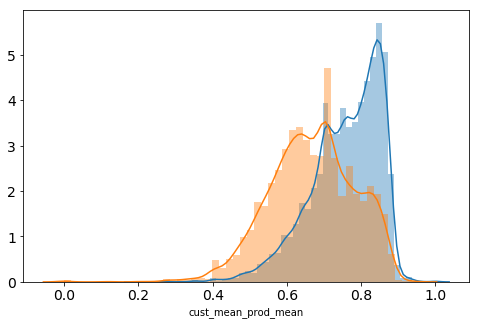

In [22]:
plt.figure(figsize=(8, 5));
sns.distplot(new_users_matrix[new_users_matrix.sex == 1]['cust_mean_prod_mean'])
sns.distplot(new_users_matrix[new_users_matrix.sex == 0]['cust_mean_prod_mean']);


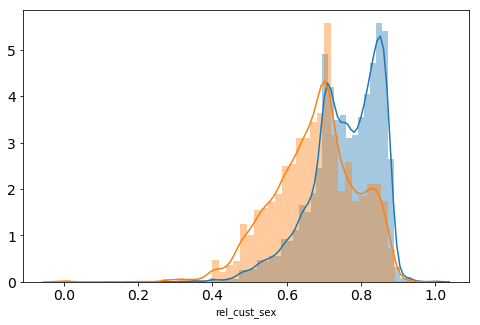

In [23]:
plt.figure(figsize=(8, 5));
sns.distplot(new_users_matrix[new_users_matrix.sex == 1]['rel_cust_sex'])
sns.distplot(new_users_matrix[new_users_matrix.sex == 0]['rel_cust_sex']);


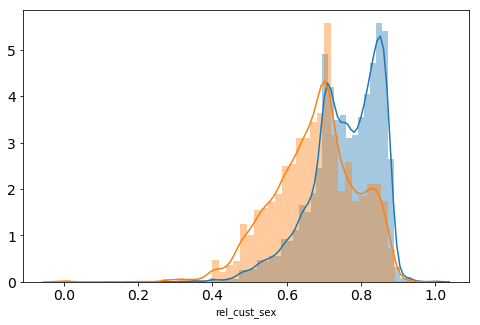

In [24]:
plt.figure(figsize=(8, 5));
sns.distplot(new_users_matrix[new_users_matrix.sex == 1]['rel_cust_sex'])
sns.distplot(new_users_matrix[new_users_matrix.sex == 0]['rel_cust_sex']);


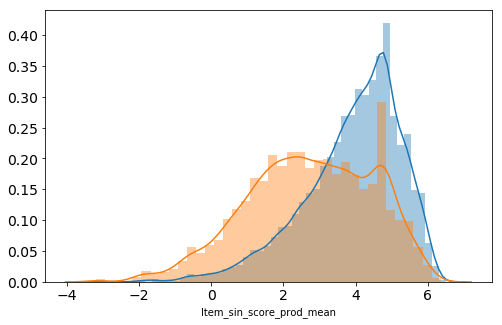

In [25]:
plt.figure(figsize=(8, 5));
sns.distplot(new_users_matrix[new_users_matrix.sex == 1]['Item_sin_score_prod_mean'])
sns.distplot(new_users_matrix[new_users_matrix.sex == 0]['Item_sin_score_prod_mean']);


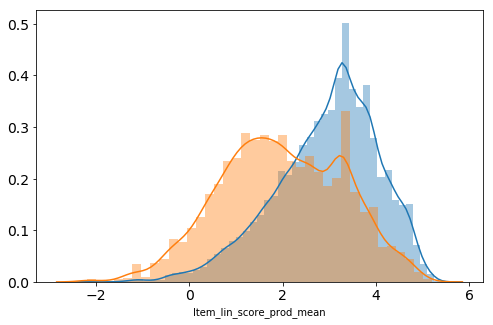

In [26]:
plt.figure(figsize=(8, 5));
sns.distplot(new_users_matrix[new_users_matrix.sex == 1]['Item_lin_score_prod_mean'])
sns.distplot(new_users_matrix[new_users_matrix.sex == 0]['Item_lin_score_prod_mean']);


### Из ниже представленной гистограммы видно, что среди людей, которые купили >= 4 уникальных item-ов немного большее количество женщин. И наоборот мужчины более скудны с точки зрения разнообразия покупаемых item-ов.

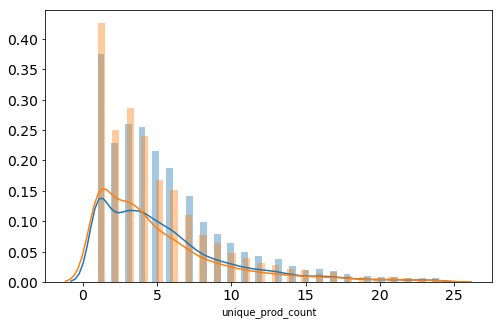

In [27]:
plt.figure(figsize=(8, 5));
sns.distplot(new_users_matrix[(new_users_matrix.sex == 1) & (new_users_matrix['unique_prod_count']<25)]['unique_prod_count'])
sns.distplot(new_users_matrix[(new_users_matrix.sex == 0) & (new_users_matrix['unique_prod_count']<25)]['unique_prod_count']);


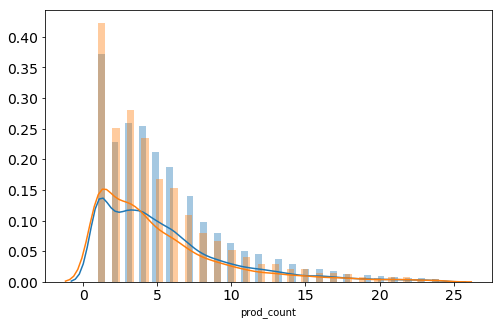

In [28]:
plt.figure(figsize=(8, 5));
sns.distplot(new_users_matrix[(new_users_matrix.sex == 1) & (new_users_matrix['prod_count']<25)]['prod_count'])
sns.distplot(new_users_matrix[(new_users_matrix.sex == 0) & (new_users_matrix['prod_count']<25)]['prod_count']);


In [29]:
new_users_matrix[['unique_prod_count', 'prod_count']].describe(percentiles=np.round(np.arange(0, 1, .1), 2))

,unique_prod_count,prod_count
count,107491.000000,107491.000000
mean,3.170238,3.271772
std,5.935078,8.610816
min,1.000000,1.000000
0%,1.000000,1.000000
10%,1.000000,1.000000
20%,1.000000,1.000000
30%,1.000000,1.000000
40%,1.000000,1.000000
50%,1.000000,1.000000


## Исходя из выше представленного распределения видно, что свыше 50% кастомеров купили всего лишь 1 продукт.

### Сформируем отдельно матрицу продуктов с соотвтствующими признаками

In [30]:
item_clmns = ['product_id', 'datetime', 'unique_cust_count_sex_known', 'unique_female_count_sex_known',
       'cust_mean', 'cust_median', 'unique_cust_count_all_sex', 'cust_count',
       'unique_cust_count_all_sex_last_month', 'cust_count_last_month',
       'Item_sin_score', 'Item_lin_score',]
new_items_matrix = purchases_train.drop_duplicates('product_id')[item_clmns].reset_index(drop=True)
new_items_matrix.shape

(1792, 12)

In [ ]:
new_items_matrix = pd.read_csv('new_items_matrix.csv', sep=';')

In [31]:
new_items_matrix[['unique_cust_count_all_sex', 'cust_count']].describe(percentiles=np.round(np.arange(0, 1, .1), 2))

,unique_cust_count_all_sex,cust_count
count,1792.000000,1792.000000
mean,190.162946,196.253348
std,504.045972,509.804397
min,1.000000,1.000000
0%,1.000000,1.000000
10%,3.000000,3.000000
20%,12.000000,12.000000
30%,22.000000,23.000000
40%,38.400000,39.000000
50%,62.500000,64.500000


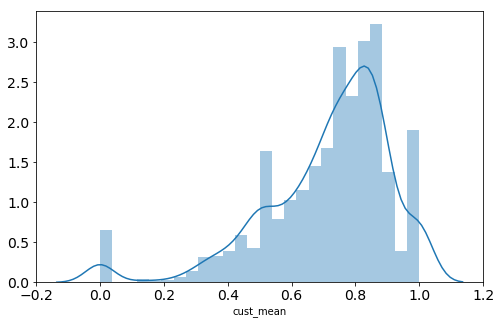

In [32]:
plt.figure(figsize=(8, 5));
sns.distplot(new_items_matrix['cust_mean'])


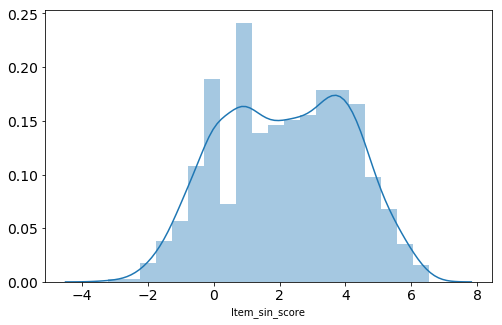

In [33]:
plt.figure(figsize=(8, 5));
sns.distplot(new_items_matrix['Item_sin_score'])


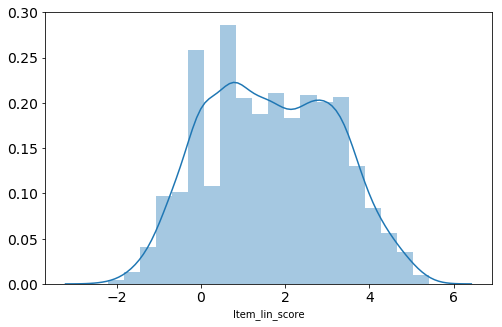

In [34]:
plt.figure(figsize=(8, 5));
sns.distplot(new_items_matrix['Item_lin_score'])


## Определяем модель, которая будет рекомендовать на основе близости кастомера к продукту и популярности продукта. Также, если кастомер купил за период обучающей выборки <=N уникальных продуктов (cold-start), то будет предсказывать наиболее популярный продукт.

In [ ]:
# user_clmns = ['customer_id', 'datetime', 'sex', 'unique_prod_count',
#                'cust_mean_prod_mean', 'cust_mean_prod_median', 'cust_mean_prod_min',
#                'cust_mean_prod_max', 'cust_mean_prod_std', 'cust_mean_values',
#                'Item_sin_score_prod_mean', 'Item_sin_score_prod_median',
#                'Item_sin_score_prod_min', 'Item_sin_score_prod_max',
#                'Item_sin_score_prod_std', 'Item_sin_score_values',
#                'Item_lin_score_prod_mean', 'Item_lin_score_prod_median',
#                'Item_lin_score_prod_min', 'Item_lin_score_prod_max',
#                'Item_lin_score_prod_std', 'Item_lin_score_values', 'prod_count',
#               'product_ids', 'rel_cust_sex'
#              ]
# item_clmns = ['product_id', 'datetime', 'unique_cust_count_sex_known', 'unique_female_count_sex_known',
#        'cust_mean', 'cust_median', 'unique_cust_count_all_sex', 'cust_count',
#        'unique_cust_count_all_sex_last_month', 'cust_count_last_month',
#        'Item_sin_score', 'Item_lin_score',]

In [33]:
class Model():
    def __init__(self, user_matrix, item_matrix, cold_start_n, cold_start_func=1, rec_func=1):
        self.cold_start_n = cold_start_n
        self.user_matrix = user_matrix
        self.item_matrix = item_matrix
        
        if cold_start_func == 1:
            self.cold_start_func = self.rec_most_unique_pop
        elif cold_start_func == 2:
            self.cold_start_func = self.rec_most_pop
        elif cold_start_func == 3:
            self.cold_start_func = self.rec_most_unique_pop_last_month
        elif cold_start_func == 4:
            self.cold_start_func = self.rec_most_pop_last_month
            
        if rec_func == 1:
            self.rec_func = self.rec_cust_mean_prod_mean
        elif rec_func == 2:
            self.rec_func = self.rec_Item_sin_score_prod_mean
        elif rec_func == 3:
            self.rec_func = self.rec_Item_lin_score_prod_mean
        
    
    # since for the cold-start problem we dont have enough information to get any prefernces about item - 
    # therefore we predict the most popular items despite sexual information
    def rec_most_unique_pop_last_month(self, user): 
        tmp = self.item_matrix[~self.item_matrix.product_id.isin(user.product_ids)].sort_values('unique_cust_count_all_sex_last_month', ascending=False)
        return tmp[['product_id', 'unique_cust_count_all_sex_last_month']].values
    
    def rec_most_pop_last_month(self, user): 
        tmp = self.item_matrix[~self.item_matrix.product_id.isin(user.product_ids)].sort_values('cust_count_last_month', ascending=False)
        return tmp[['product_id', 'cust_count_last_month']].values
    
    def rec_most_unique_pop(self, user): 
        tmp = self.item_matrix[~self.item_matrix.product_id.isin(user.product_ids)].sort_values('unique_cust_count_all_sex', ascending=False)
        return tmp[['product_id', 'unique_cust_count_all_sex']].values
    
    def rec_most_pop(self, user): 
        tmp = self.item_matrix[~self.item_matrix.product_id.isin(user.product_ids)].sort_values('cust_count', ascending=False)
        return tmp[['product_id', 'cust_count']].values
        
    
    
    # recommend functions based on similarity between user and item
    def rec_cust_mean_prod_mean(self, user):
        tmp = self.item_matrix[~self.item_matrix.product_id.isin(user.product_ids)].reset_index(drop=True)
        tmp['score'] = (1 - abs(tmp.cust_mean.values - user.cust_mean_prod_median)) * np.log(tmp.cust_count.values + 1)
        return tmp.sort_values('score', ascending=False)[['product_id', 'score']].values
    
    def rec_Item_sin_score_prod_mean(self, user):
        tmp = self.item_matrix[~self.item_matrix.product_id.isin(user.product_ids)].reset_index(drop=True)
        tmp['score'] = (10 - abs(tmp.Item_sin_score.values - user.Item_sin_score_prod_median)) * np.log(tmp.cust_count.values + 1)
        return tmp.sort_values('score', ascending=False)[['product_id', 'score']].values
    
    def rec_Item_lin_score_prod_mean(self, user):
        tmp = self.item_matrix[~self.item_matrix.product_id.isin(user.product_ids)].reset_index(drop=True)
        tmp['score'] = (10 - abs(tmp.Item_lin_score.values - user.Item_lin_score_prod_median)) * np.log(tmp.cust_count.values + 1)
        return tmp.sort_values('score', ascending=False)[['product_id', 'score']].values

    
        
    def recommend(self, user_id, k=10):
        try:
            user = self.user_matrix.loc[self.user_matrix.customer_id == user_id].iloc[0]
            return self.cold_start_func(user)[:k].T
            if user.unique_prod_count <= self.cold_start_n: #cold_start
#                 print('cold')
                return self.cold_start_func(user)[:k].T
#                 return self.rec_most_unique_pop(user)[:10]
#                 return self.rec_most_pop(user)[:10]
            else:
#                 print('hot')
                return self.rec_func(user)[:k].T
#                 return self.rec_cust_mean_prod_mean(user)[:10]
#                 return self.rec_Item_sin_score_prod_mean(user)[:10]
#                 return self.rec_Item_lin_score_prod_mean(user)[:10]
        except Exception as e:
            print(e)
            user = self.user_matrix.loc[self.user_matrix.customer_id == user_id]
            print(user.shape)
            
            return None
#             tmp = self.item_matrix.sort_values('unique_cust_count_all_sex', ascending=False)
#             return tmp[['product_id', 'unique_cust_count_all_sex']].values
#             tmp = self.item_matrix.sort_values('unique_cust_count_all_sex', ascending=False)
#             return tmp[['product_id', 'cust_count']].values
            


In [31]:
new_users_matrix.to_csv('new_users_matrix.csv', sep=';')
new_items_matrix.to_csv('new_items_matrix.csv', sep=';')

In [227]:
# # recommendations = []
# for cold_st in [3, 4, 5, 6, 7, 8, 9, 10]:
#     recommendations = []
#     print('cold_st', cold_st)
#     mdl = Model(new_users_matrix, new_items_matrix, cold_st)
#     for ind, user_id in enumerate(relevant['customer_id'].values):
#         if ind%3000 == 0:
#             print(ind, relevant.shape[0])
#         recommendations.append([x[0] for x in mdl.recommend(user_id)])
#     print('cold_st:', cold_st, 'mapk', mapk(relevant['product_ids'], recommendations, k=10))

cold_st 3
0 12502
3000 12502
6000 12502
9000 12502
12000 12502
cold_st: 3 mapk 0.15062897872848277
cold_st 4
0 12502
3000 12502
6000 12502
9000 12502
12000 12502
cold_st: 4 mapk 0.15557085469499482
cold_st 5
0 12502
3000 12502
6000 12502
9000 12502
12000 12502
cold_st: 5 mapk 0.15918627622754963
cold_st 6
0 12502
3000 12502
6000 12502
9000 12502
12000 12502
cold_st: 6 mapk 0.1625053959620429
cold_st 7
0 12502
3000 12502
6000 12502
9000 12502
12000 12502
cold_st: 7 mapk 0.16589628199170672
cold_st 8
0 12502
3000 12502
6000 12502
9000 12502
12000 12502
cold_st: 8 mapk 0.1683585546947409
cold_st 9
0 12502
3000 12502
6000 12502
9000 12502
12000 12502
cold_st: 9 mapk 0.1701476017805405
cold_st 10
0 12502
3000 12502
6000 12502
9000 12502
12000 12502
cold_st: 10 mapk 0.17159955994342493


## Предсказания только на основании близости кастомера с продуктами (без холодного старта). Результат - все модели основанные на разных скорах хуже бейзлайна.

In [44]:
# cust_mean
recommendations = []
mdl = Model(new_users_matrix, new_items_matrix, 0, 1, 1)
for ind, user_id in enumerate(relevant['customer_id'].values):
    recommendations.append([x[0] for x in mdl.recommend(user_id)])
print('cust_mean mapk', mapk(relevant['product_ids'], recommendations, k=10))

# Item_sin_score
recommendations = []
mdl = Model(new_users_matrix, new_items_matrix, 0, 1, 2)
for ind, user_id in enumerate(relevant['customer_id'].values):
    recommendations.append([x[0] for x in mdl.recommend(user_id)])
print('Item_sin_score mapk', mapk(relevant['product_ids'], recommendations, k=10))

# Item_lin_score
recommendations = []
mdl = Model(new_users_matrix, new_items_matrix, 0, 1, 3)
for ind, user_id in enumerate(relevant['customer_id'].values):
    recommendations.append([x[0] for x in mdl.recommend(user_id)])
print('Item_lin_score mapk', mapk(relevant['product_ids'], recommendations, k=10))

cust_mean mapk 0.12503307407322764
Item_sin_score mapk 0.06447758834776911
Item_lin_score mapk 0.053121913192301924


## Рекомендации только в соответствии с холодным стартом (наиболее популярные продукты за весь период обучающей выборке) оказались лучше по mapK метрике как для мужчин, женщин, так и для кастомеров, чей пол нам неизвестен. Результаты ниже

In [34]:
# prdicting for males
recommendations = []
cond = new_users_matrix.sex == 0
cond1 = relevant.sex == 0
mdl = Model(new_users_matrix[cond], new_items_matrix, 3, 1)
for ind, user_id in enumerate(relevant[cond1]['customer_id'].values):
#     if ind%3000 == 0:
#         print(ind, relevant.shape[0])
    recommendations.append([x[0] for x in mdl.recommend(user_id)])
print('males mapk', mapk(relevant[cond1]['product_ids'], recommendations, k=10))

males mapk 0.13115482792007746


In [35]:
# prdicting for females
recommendations = []
cond = new_users_matrix.sex == 1
cond1 = relevant.sex == 1
mdl = Model(new_users_matrix[cond], new_items_matrix, 3, 1)
for ind, user_id in enumerate(relevant[cond1]['customer_id'].values):
#     if ind%3000 == 0:
#         print(ind, relevant.shape[0])
    recommendations.append([x[0] for x in mdl.recommend(user_id)])
print('females mapk', mapk(relevant[cond1]['product_ids'], recommendations, k=10))

females mapk 0.105226084821817


In [36]:
# prdicting for gender-unknown
recommendations = []
cond = new_users_matrix.sex == 0.5
cond1 = relevant.sex == 0.5
mdl = Model(new_users_matrix[cond], new_items_matrix, 3, 1)
for ind, user_id in enumerate(relevant[cond1]['customer_id'].values):
#     if ind%3000 == 0:
#         print(ind, relevant.shape[0])
    recommendations.append([x[0] for x in mdl.recommend(user_id)])
print('gender unknown mapk', mapk(relevant[cond1]['product_ids'], recommendations, k=10))

gender unknown mapk 0.25317989784719985


## Рекомендация наиболее популярных продуктов за последние 30 дней оказались немного лучше, чем предсказание наиболее популярных продуктов за весь период.

In [37]:
# prdicting for males
recommendations = []
cond = new_users_matrix.sex == 0
cond1 = relevant.sex == 0
mdl = Model(new_users_matrix[cond], new_items_matrix, 3, 3)
for ind, user_id in enumerate(relevant[cond1]['customer_id'].values):
#     if ind%3000 == 0:
#         print(ind, relevant.shape[0])
    recommendations.append([x[0] for x in mdl.recommend(user_id)])
print('males mapk', mapk(relevant[cond1]['product_ids'], recommendations, k=10))

males mapk 0.13325998298271866


In [38]:
# prdicting for females
recommendations = []
cond = new_users_matrix.sex == 1
cond1 = relevant.sex == 1
mdl = Model(new_users_matrix[cond], new_items_matrix, 3, 3)
for ind, user_id in enumerate(relevant[cond1]['customer_id'].values):
#     if ind%3000 == 0:
#         print(ind, relevant.shape[0])
    recommendations.append([x[0] for x in mdl.recommend(user_id)])
print('females mapk', mapk(relevant[cond1]['product_ids'], recommendations, k=10))

females mapk 0.10645105405774943


In [39]:
# prdicting for gender-unknown
recommendations = []
cond = new_users_matrix.sex == 0.5
cond1 = relevant.sex == 0.5
mdl = Model(new_users_matrix[cond], new_items_matrix, 3, 3)
for ind, user_id in enumerate(relevant[cond1]['customer_id'].values):
#     if ind%3000 == 0:
#         print(ind, relevant.shape[0])
    recommendations.append([x[0] for x in mdl.recommend(user_id)])
print('gender unknown mapk', mapk(relevant[cond1]['product_ids'], recommendations, k=10))

gender unknown mapk 0.2582339035076862


## Результаты по целой тестовой выборке для моделей холодного старта

In [40]:
# prdicting the most popular items a customer never bought before according to training dataset 
recommendations = []
mdl = Model(new_users_matrix, new_items_matrix, 1, 1)#, 2)
for ind, user_id in enumerate(relevant['customer_id'].values):
#     if ind%3000 == 0:
#         print(ind, relevant.shape[0])
    recommendations.append([x[0] for x in mdl.recommend(user_id)])
print('cold_start_func (most popular items in training dataset) mapk', mapk(relevant['product_ids'], recommendations, k=10))


cold_start_func (most popular items in training dataset) mapk 0.17688852323310808


In [41]:
# prdicting the most popular items on the last month purchases a customer never bought before according to training dataset 
recommendations = []
mdl = Model(new_users_matrix, new_items_matrix, 1, 3)
for ind, user_id in enumerate(relevant['customer_id'].values):
#     if ind%3000 == 0:
#         print(ind, relevant.shape[0])
    recommendations.append([x[0] for x in mdl.recommend(user_id)])
print('cold_start_func (most popular items in training dataset in the last month) mapk', mapk(relevant['product_ids'], recommendations, k=10))

cold_start_func (most popular items in training dataset in the last month) mapk 0.17999526424978354


## Попытаемся объединить модель, получившуюся в результате Часть 1 с лучшей моделью, на основе холодного старта и подобрать такое N, при котором получившийся ансамбль моделей дает лучшее качество на тестовой выборке.

In [9]:
# optional
new_users_matrix = pd.read_csv('new_users_matrix.csv', sep=';')
new_users_matrix.product_ids = new_users_matrix.product_ids.apply(lambda x: np.fromstring(x[1:-1], dtype=int, sep=' '))

new_items_matrix = pd.read_csv('new_items_matrix.csv', sep=';')

In [15]:
relevant = relevant.merge(new_users_matrix[['customer_id', 'unique_prod_count']], on='customer_id', how='left')

In [16]:
mdl = Model(new_users_matrix, new_items_matrix, 1, 3)#, 2)
for i in range(1, 12):
    cond = purchases_train.unique_prod_count > i
    # purchases_train[purchases_train.unique_prod_count > N]
    
    print(i)
    als_combined = Als(purchases_train, cond)
    als_combined.fit()
    
    recommendations = []
    for ind, user in relevant.iterrows():
        user = user
        if user.unique_prod_count <= i:
            recommendations.append([x[0] for x in mdl.recommend(user.customer_id)])
        else:
            recommendations.append([x[0] for x in als_combined.recommend(user.customer_id)])
    print('N:', i, 'mapk:', mapk(relevant['product_ids'], recommendations, k=10))

    del als_combined
    gc.collect()

1
sparsity: 99.68410156354885


GPU training requires factor size to be a multiple of 32. Increasing factors from 16 to 32.


Fit the model...



N: 1 mapk: 0.17024726892777525
2
sparsity: 99.59411872437863


Fit the model...



N: 2 mapk: 0.15175383156885877
3
sparsity: 99.5009507634391


Fit the model...



N: 3 mapk: 0.15995634906024006
4
sparsity: 99.41440804453991


Fit the model...



N: 4 mapk: 0.16331135643895361
5
sparsity: 99.32990660695845


Fit the model...



N: 5 mapk: 0.16564511333515433
6
sparsity: 99.23263915658006


Fit the model...



N: 6 mapk: 0.16833826861070839
7
sparsity: 99.13324119021824


Fit the model...



N: 7 mapk: 0.17052537246597863
8
sparsity: 99.03625601795326


Fit the model...



N: 8 mapk: 0.173556764125097
9
sparsity: 98.94031174443694


Fit the model...



N: 9 mapk: 0.1753130128053283
10
sparsity: 98.84039190182102


Fit the model...



N: 10 mapk: 0.1763062123716038
11
sparsity: 98.74163272765246


Fit the model...



N: 11 mapk: 0.17721444701122954


In [22]:
mdl = Model(new_users_matrix, new_items_matrix, 1, 3)#, 2)
for i in range(1, 12):
    cond = purchases_train.unique_prod_count > i
    # purchases_train[purchases_train.unique_prod_count > N]
    
    print(i)
    als_combined = Als(purchases_train, cond)
    als_combined.fit({'factors': 32, 'regularization': 0.01, 'iterations': 100})
    
    recommendations = []
    cond1 = relevant.unique_prod_count > i
    for ind, user in relevant[cond1].iterrows():
        user = user
#         if user.unique_prod_count <= i:
#             recommendations.append([x[0] for x in mdl.recommend(user.customer_id)])
#         else:
        recommendations.append([x[0] for x in als_combined.recommend(user.customer_id)])
    print('N:', i, 'mapk:', mapk(relevant[cond1]['product_ids'], recommendations, k=10))

    del als_combined
    gc.collect()

1
sparsity: 99.68410156354885
Fit the model...



N: 1 mapk: 0.14480567266126151
2
sparsity: 99.59411872437863
Fit the model...


KeyboardInterrupt: 

## Объединение результатов не дает прироста по сравнению с лучшей моделью холодного старта.

In [ ]:
new_users_matrix = pd.read_csv('new_users_matrix.csv', sep=';')
new_users_matrix.product_ids = new_users_matrix.product_ids.apply(lambda x: np.fromstring(x[1:-1], dtype=int, sep=' '))

new_items_matrix = pd.read_csv('new_items_matrix.csv', sep=';')


# Часть 3: Предсказать пол кастомеров, чей пол нам неизвестен и опять попробовать построить рекомендательную модель из Части 2 предварительно посчитав cust_mean для всех кастомеров. 

## Часть 3.1: Предсказание пола с помощью логистической регресии + BoW

In [35]:
from sklearn.feature_extraction import DictVectorizer

In [36]:
cond = purchases_train.sex != 0.5
tmp = purchases_train[cond].drop_duplicates(['customer_id', 'product_id']).groupby('customer_id').apply(lambda x: dict(zip(x.product_id.values, np.ones(shape=(x.shape[0],) )))).values
y = purchases_train[cond].groupby('customer_id')['sex'].first().values


In [37]:
dv = DictVectorizer()
vls = dv.fit_transform(tmp)
vls.shape

(31943, 1724)

In [38]:
test_size = 0.2
random_state = 632
x_train, x_test, y_train, y_test = train_test_split(vls, y, test_size=test_size, random_state=random_state)


In [39]:
model = LogisticRegression(C=1)
model.fit(x_train, y_train)

C:\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
print ('VALIDATION:')
train_pred = model.predict_proba(x_train).T[1]
test_pred = model.predict_proba(x_test).T[1]

train_prc_auc_score = average_precision_score(y_train, train_pred)
test_prc_auc_score = average_precision_score(y_test, test_pred)

train_precision, train_recall, thres = precision_recall_curve(y_train, train_pred)
train_prc_auc = auc(train_recall, train_precision)

test_precision, test_recall, thres = precision_recall_curve(y_test, test_pred)
test_prc_auc = auc(test_recall, test_precision)

print ('TRAIN ROC_AUC:', round(roc_auc_score(y_train, train_pred), 6), 'PRC_AUC:', round(train_prc_auc, 6), 'PRC_AUC_SCORE:', round(train_prc_auc_score, 6), 'ACCURACY:', round(accuracy_score(y_train, np.round(train_pred)), 6))
print ('TEST ROC_AUC:', round(roc_auc_score(y_test, test_pred), 6), 'PRC_AUC:', round(test_prc_auc, 6), 'PRC_AUC_SCORE:', round(test_prc_auc_score, 6), 'ACCURACY:', round(accuracy_score(y_test, np.round(test_pred)), 6))

VALIDATION:
TRAIN ROC_AUC: 0.767932 PRC_AUC: 0.890895 PRC_AUC_SCORE: 0.890784 ACCURACY: 0.77393
TEST ROC_AUC: 0.692245 PRC_AUC: 0.847714 PRC_AUC_SCORE: 0.847794 ACCURACY: 0.753483


### Исходя из результатов, я делаю вывод, что модель немного переобучилась и если при ее использовании при предсказании пола встретятся кастомеры, которые не купили ни 1 продукт из обучающейся выборки, то модель будет предсказывать все время либо женщину, либо мужчину (в зависимости от параметра байеса). Поэтому эту модель для предсказания в дальнейшем не буду использовать.

## Часть 3.2: предсказание пола, где в качестве фичей выступают распределение по cust_mean, Item_sin_score, Item_lin_score

In [41]:
# [purchases_train['sex'] != 0.5]
# take a patience - it takes about 7 minutes for me
tmp = purchases_train.drop_duplicates(['customer_id', 'product_id']).groupby('customer_id').agg({'sex': [('sex', lambda x: round(x.iloc[0], 2))],
                                            'cust_mean': [('cust_mean_perc_0', lambda x: np.percentile(x, 0)), 
                                                         ('cust_mean_perc_10', lambda x: np.percentile(x, 10)), 
                                                         ('cust_mean_perc_20', lambda x: np.percentile(x, 20)), 
                                                         ('cust_mean_perc_30', lambda x: np.percentile(x, 30)), 
                                                         ('cust_mean_perc_40', lambda x: np.percentile(x, 40)), 
                                                         ('cust_mean_perc_50', lambda x: np.percentile(x, 50)), 
                                                         ('cust_mean_perc_60', lambda x: np.percentile(x, 60)), 
                                                         ('cust_mean_perc_70', lambda x: np.percentile(x, 70)), 
                                                         ('cust_mean_perc_80', lambda x: np.percentile(x, 80)), 
                                                         ('cust_mean_perc_90', lambda x: np.percentile(x, 90)), 
                                                         ('cust_mean_perc_100', lambda x: np.percentile(x, 100)), 
                                                         ('cnt', len)],
                                            'Item_sin_score': [('Item_sin_score_perc_0', lambda x: np.percentile(x, 0)), 
                                                         ('Item_sin_score_perc_10', lambda x: np.percentile(x, 10)), 
                                                         ('Item_sin_score_perc_20', lambda x: np.percentile(x, 20)), 
                                                         ('Item_sin_score_perc_30', lambda x: np.percentile(x, 30)), 
                                                         ('Item_sin_score_perc_40', lambda x: np.percentile(x, 40)), 
                                                         ('Item_sin_score_perc_50', lambda x: np.percentile(x, 50)), 
                                                         ('Item_sin_score_perc_60', lambda x: np.percentile(x, 60)), 
                                                         ('Item_sin_score_perc_70', lambda x: np.percentile(x, 70)), 
                                                         ('Item_sin_score_perc_80', lambda x: np.percentile(x, 80)), 
                                                         ('Item_sin_score_perc_90', lambda x: np.percentile(x, 90)), 
                                                         ('Item_sin_score_perc_100', lambda x: np.percentile(x, 100)), 
                                                         ],
                                            'Item_lin_score': [('Item_lin_score_perc_0', lambda x: np.percentile(x, 0)), 
                                                         ('Item_lin_score_perc_10', lambda x: np.percentile(x, 10)), 
                                                         ('Item_lin_score_perc_20', lambda x: np.percentile(x, 20)), 
                                                         ('Item_lin_score_perc_30', lambda x: np.percentile(x, 30)), 
                                                         ('Item_lin_score_perc_40', lambda x: np.percentile(x, 40)), 
                                                         ('Item_lin_score_perc_50', lambda x: np.percentile(x, 50)), 
                                                         ('Item_lin_score_perc_60', lambda x: np.percentile(x, 60)), 
                                                         ('Item_lin_score_perc_70', lambda x: np.percentile(x, 70)), 
                                                         ('Item_lin_score_perc_80', lambda x: np.percentile(x, 80)), 
                                                         ('Item_lin_score_perc_90', lambda x: np.percentile(x, 90)), 
                                                         ('Item_lin_score_perc_100', lambda x: np.percentile(x, 100)), 
                                                         ],
                                           }).reset_index()
tmp.columns = tmp.columns.droplevel()
tmp.rename(columns= {'': 'customer_id'}, inplace=True)
tmp.head()

,customer_id,sex,cust_mean_perc_0,cust_mean_perc_10,cust_mean_perc_20,cust_mean_perc_30,cust_mean_perc_40,cust_mean_perc_50,cust_mean_perc_60,cust_mean_perc_70,cust_mean_perc_80,cust_mean_perc_90,cust_mean_perc_100,cnt,Item_sin_score_perc_0,Item_sin_score_perc_10,Item_sin_score_perc_20,Item_sin_score_perc_30,Item_sin_score_perc_40,Item_sin_score_perc_50,Item_sin_score_perc_60,Item_sin_score_perc_70,Item_sin_score_perc_80,Item_sin_score_perc_90,Item_sin_score_perc_100,Item_lin_score_perc_0,Item_lin_score_perc_10,Item_lin_score_perc_20,Item_lin_score_perc_30,Item_lin_score_perc_40,Item_lin_score_perc_50,Item_lin_score_perc_60,Item_lin_score_perc_70,Item_lin_score_perc_80,Item_lin_score_perc_90,Item_lin_score_perc_100
0,107,0.5,0.61893,0.632878,0.646826,0.660774,0.674722,0.68867,0.702618,0.716566,0.730514,0.744462,0.75841,2.0,2.44168,2.740737,3.039794,3.338851,3.637908,3.936965,4.236022,4.535079,4.834136,5.133193,5.43225,1.59119,1.819023,2.046856,2.274689,2.502522,2.730355,2.958188,3.186021,3.413854,3.641687,3.86952
1,351,0.5,0.75556,0.755560,0.755560,0.755560,0.755560,0.75556,0.755560,0.755560,0.755560,0.755560,0.75556,1.0,4.02988,4.029880,4.029880,4.029880,4.029880,4.029880,4.029880,4.029880,4.029880,4.029880,4.02988,2.86335,2.863350,2.863350,2.863350,2.863350,2.863350,2.863350,2.863350,2.863350,2.863350,2.86335
2,357,0.5,0.93333,0.933330,0.933330,0.933330,0.933330,0.93333,0.933330,0.933330,0.933330,0.933330,0.93333,1.0,3.74497,3.744970,3.744970,3.744970,3.744970,3.744970,3.744970,3.744970,3.744970,3.744970,3.74497,3.31813,3.318130,3.318130,3.318130,3.318130,3.318130,3.318130,3.318130,3.318130,3.318130,3.31813
3,434,1.0,0.62100,0.630952,0.674636,0.705316,0.710640,0.71264,0.728176,0.740280,0.781128,0.839034,0.85845,9.0,2.25762,2.321644,2.599124,2.997680,3.379630,3.561990,4.118718,4.589598,4.958998,5.316736,5.85808,1.47245,1.520642,1.755548,2.082084,2.375564,2.481700,2.830788,3.134312,3.564152,4.124550,4.65211
4,453,0.0,0.70210,0.702100,0.702100,0.702100,0.702100,0.70210,0.702100,0.702100,0.702100,0.702100,0.70210,1.0,4.81073,4.810730,4.810730,4.810730,4.810730,4.810730,4.810730,4.810730,4.810730,4.810730,4.81073,3.27848,3.278480,3.278480,3.278480,3.278480,3.278480,3.278480,3.278480,3.278480,3.278480,3.27848


In [42]:
def plot_fe(series, xlabel='', ylabel='', title='', figsize=(13, 10), font_size=14, sort=True):
    if sort:
        series = series.sort_values(ascending=False)
        
    plt.figure(figsize=figsize);
    sns.set(font_scale=font_size/10.0)
    ax = sns.barplot(x=series.values.reshape(1, -1)[0], y=series.index);
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=font_size)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=font_size)
    if title:
        ax.set_title(title, fontsize=font_size)
    plt.show()
    
def preproc_data(ldf, pred_clmns, y_col, test_size=0.2, random_state=523, cond=None):
    if cond is None:
        x_train, x_test, y_train, y_test = train_test_split(ldf[pred_clmns], ldf[y_col], test_size=test_size, random_state=random_state)
    else:
        x_train, x_test, y_train, y_test = train_test_split(ldf.loc[cond, pred_clmns], ldf.loc[cond, y_col], test_size=test_size, random_state=random_state)
        
        
    print ('TRAIN SHAPE:', x_train.shape, 'TEST SHAPE:', x_test.shape)
    return x_train, x_test, y_train, y_test

def fit_model(params, x_train, x_test, y_train, y_test, weight_train=None, weight_test=None, modelname='lgb'):
    if modelname=='lgb':
        # define lgb train and validation Datasets
        d_train = lgb.Dataset(x_train, y_train, weight=weight_train)
        d_valid = lgb.Dataset(x_test, y_test, weight=weight_test)

        # train model
        print ('\nSTART FITTING:')
        model = lgb.train(params=params, 
                        train_set=d_train, 
                        num_boost_round=5000, 
                        valid_sets=[d_valid],
                        verbose_eval=100, 
                        early_stopping_rounds=25)
        print ('FITTING HAS BEEN ENDED\n')
        
        print ('VALIDATION:')
        if params['objective']=='binary':
            train_pred = model.predict(x_train)
            test_pred = model.predict(x_test)
            
            train_prc_auc_score = average_precision_score(y_train, train_pred, sample_weight=weight_train)
            test_prc_auc_score = average_precision_score(y_test, test_pred, sample_weight=weight_test)
            
#             train_precision, train_recall, thres = precision_recall_curve(y_train, train_pred, sample_weight=weight_train)
#             train_prc_auc = auc(train_recall, train_precision)
            
#             test_precision, test_recall, thres = precision_recall_curve(y_test, test_pred, sample_weight=weight_test)
#             test_prc_auc = auc(test_recall, test_precision)

#             print ('TRAIN ROC_AUC:', round(roc_auc_score(y_train, train_pred, sample_weight=weight_train), 6), 'PRC_AUC:', round(train_prc_auc, 6), 'PRC_AUC_SCORE:', round(train_prc_auc_score, 6), 'ACCURACY:', round(accuracy_score(y_train, np.round(train_pred), sample_weight=weight_train), 6))
#             print ('TEST ROC_AUC:', round(roc_auc_score(y_test, test_pred, sample_weight=weight_test), 6), 'PRC_AUC:', round(test_prc_auc, 6), 'PRC_AUC_SCORE:', round(test_prc_auc_score, 6), 'ACCURACY:', round(accuracy_score(y_test, np.round(test_pred), sample_weight=weight_test), 6))
            print ('TRAIN ROC_AUC:', round(roc_auc_score(y_train, train_pred, sample_weight=weight_train), 6), 'PRC_AUC_SCORE:', round(train_prc_auc_score, 6), 'ACCURACY:', round(accuracy_score(y_train, np.round(train_pred), sample_weight=weight_train), 6))
            print ('TEST ROC_AUC:', round(roc_auc_score(y_test, test_pred, sample_weight=weight_test), 6), 'PRC_AUC_SCORE:', round(test_prc_auc_score, 6), 'ACCURACY:', round(accuracy_score(y_test, np.round(test_pred), sample_weight=weight_test), 6))
            
            
        return model
    
    elif modelname=='logreg':
        model = LogisticRegression(**params)
        print ('\nSTART FITTING:')
        model.fit(x_train, y_train, sample_weight=weight_train)
        print ('FITTING HAS BEEN ENDED\n')
        
        print ('VALIDATION:')
        train_pred = model.predict_proba(x_train).T[1]
        test_pred = model.predict_proba(x_test).T[1]

        train_prc_auc_score = average_precision_score(y_train, train_pred, sample_weight=weight_train)
        test_prc_auc_score = average_precision_score(y_test, test_pred, sample_weight=weight_test)

#         train_precision, train_recall, thres = precision_recall_curve(y_train, train_pred, sample_weight=weight_train)
#         train_prc_auc = auc(train_recall, train_precision)

#         test_precision, test_recall, thres = precision_recall_curve(y_test, test_pred, sample_weight=weight_test)
#         test_prc_auc = auc(test_recall, test_precision)

#         print ('TRAIN ROC_AUC:', round(roc_auc_score(y_train, train_pred, sample_weight=weight_train), 6), 'PRC_AUC:', round(train_prc_auc, 6), 'PRC_AUC_SCORE:', round(train_prc_auc_score, 6), 'ACCURACY:', round(accuracy_score(y_train, np.round(train_pred), sample_weight=weight_train), 6))
#         print ('TEST ROC_AUC:', round(roc_auc_score(y_test, test_pred, sample_weight=weight_test), 6), 'PRC_AUC:', round(test_prc_auc, 6), 'PRC_AUC_SCORE:', round(test_prc_auc_score, 6), 'ACCURACY:', round(accuracy_score(y_test, np.round(test_pred), sample_weight=weight_test), 6))
        print ('TRAIN ROC_AUC:', round(roc_auc_score(y_train, train_pred, sample_weight=weight_train), 6), 'PRC_AUC_SCORE:', round(train_prc_auc_score, 6), 'ACCURACY:', round(accuracy_score(y_train, np.round(train_pred), sample_weight=weight_train), 6))
        print ('TEST ROC_AUC:', round(roc_auc_score(y_test, test_pred, sample_weight=weight_test), 6), 'PRC_AUC_SCORE:', round(test_prc_auc_score, 6), 'ACCURACY:', round(accuracy_score(y_test, np.round(test_pred), sample_weight=weight_test), 6))
        
        return model
    
        

In [43]:
tmp.sex.value_counts()#normalize=True

0.5    75548
1.0    23536
0.0     8407
Name: sex, dtype: int64

### Так как отношение количества женщин к количеству мужчин, чей пол нам известен составляет приблизительно 3:1, то исходя из этого мы имеем с несбалансированной выборкой. Я пробывал 2 подхода: 1 - взвешивание в соответствии с пропорциями каждого пола (семплы мужщин важнее семплов женщин); 2 - undersampling - случайным образом из выборки кастомеров, пол женщин которых нам известен, взять N семплов, где N - количество кастомеров мужского пола. Оба подхода работают приблизительно одинаково.

In [44]:
tmp['sex_weight'] = 1
tmp.loc[tmp.sex == 1, 'sex_weight'] = 1 / 0.736812#**1.6
tmp.loc[tmp.sex == 0, 'sex_weight'] = 1 / 0.263188#**1.6

In [45]:
(tmp.sex == 0).sum()

8407

In [46]:
female_indexes = tmp.loc[tmp.sex == 1].index.values
np.random.shuffle(female_indexes)
female_indexes = female_indexes[:(tmp.sex == 0).sum()] # 8407 - количество известных нам мужчин
female_indexes

array([35460, 15249, 81264, ..., 14802, 38192, 79512], dtype=int64)

### В приведенном ниже примере мы используем 1 - ый подход

In [47]:
# pred_columns = [i for i in tmp.columns.values[2:] if 'perc' in i or i == 'cnt' ]
pred_columns = [i for i in tmp.columns.values[2:] if 'perc' in i]# or i == 'cnt' ]
y_col = 'sex'
cond = tmp.sex != 0.5

####
# 1 - подход
####
# x_train, x_test, y_train, y_test = preproc_data(tmp.loc[tmp.loc[tmp.sex == 0].index.values.tolist() + female_indexes.tolist()], pred_columns, y_col, cond=cond)
x_train, x_test, y_train, y_test = preproc_data(tmp, pred_columns, y_col, cond=cond)
# weight_train = np.log(tmp[cond].loc[x_train[cond].index, 'cnt'])
# weight_test = np.log(tmp[cond].loc[x_test[cond].index, 'cnt'])
# weight_train = tmp.loc[x_train[cond].index, 'cnt'].values
# weight_test = tmp.loc[x_test[cond].index, 'cnt'].values

weight_train = np.log(tmp.loc[x_train.loc[cond].index, 'cnt'].values) * tmp.loc[x_train.loc[cond].index, 'sex_weight'].values
weight_test = np.log(tmp.loc[x_test.loc[cond].index, 'cnt'].values) * tmp.loc[x_test.loc[cond].index, 'sex_weight'].values
# weight_train = tmp.loc[x_train.loc[cond].index, 'cnt'].values * tmp.loc[x_train.loc[cond].index, 'sex_weight'].values
# weight_test = tmp.loc[x_test.loc[cond].index, 'cnt'].values * tmp.loc[x_test.loc[cond].index, 'sex_weight'].values
# weight_train = tmp.loc[x_train.loc[cond].index, 'sex_weight'].values
# weight_test = tmp.loc[x_test.loc[cond].index, 'sex_weight'].values

####
# 2 - подход
####
# x_train, x_test, y_train, y_test = preproc_data(tmp.loc[tmp.loc[tmp.sex == 0].index.values.tolist() + female_indexes.tolist()], pred_columns, y_col, cond=cond)
# # x_train, x_test, y_train, y_test = preproc_data(tmp, pred_columns, y_col, cond=cond)
# # weight_train = np.log(tmp[cond].loc[x_train[cond].index, 'cnt'])
# # weight_test = np.log(tmp[cond].loc[x_test[cond].index, 'cnt'])
# # weight_train = tmp.loc[x_train[cond].index, 'cnt'].values
# # weight_test = tmp.loc[x_test[cond].index, 'cnt'].values

# weight_train = np.log(tmp.loc[x_train.loc[cond].index, 'cnt'].values)# * tmp.loc[x_train.loc[cond].index, 'sex_weight'].values
# weight_test = np.log(tmp.loc[x_test.loc[cond].index, 'cnt'].values)# * tmp.loc[x_test.loc[cond].index, 'sex_weight'].values
# # weight_train = tmp.loc[x_train.loc[cond].index, 'cnt'].values * tmp.loc[x_train.loc[cond].index, 'sex_weight'].values
# # weight_test = tmp.loc[x_test.loc[cond].index, 'cnt'].values * tmp.loc[x_test.loc[cond].index, 'sex_weight'].values
# # weight_train = tmp.loc[x_train.loc[cond].index, 'sex_weight'].values
# # weight_test = tmp.loc[x_test.loc[cond].index, 'sex_weight'].values


TRAIN SHAPE: (25554, 33) TEST SHAPE: (6389, 33)


#### LightGBM


START FITTING:
Training until validation scores don't improve for 25 rounds.
[100]	valid_0's auc: 0.754423
Early stopping, best iteration is:
[90]	valid_0's auc: 0.754549
FITTING HAS BEEN ENDED

VALIDATION:
TRAIN ROC_AUC: 0.778271 PRC_AUC_SCORE: 0.774524 ACCURACY: 0.714497
TEST ROC_AUC: 0.754549 PRC_AUC_SCORE: 0.748944 ACCURACY: 0.691301


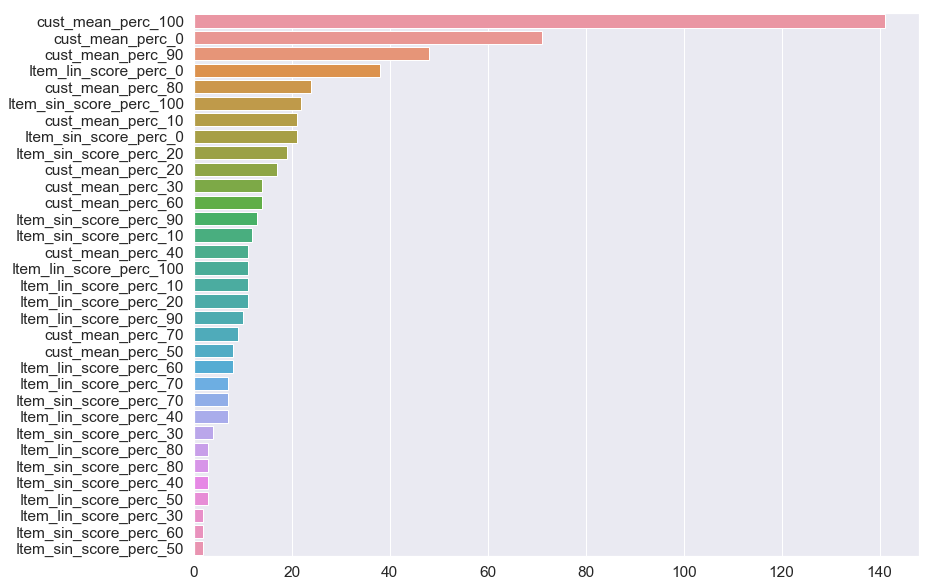

In [65]:
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'auc'},
        'num_leaves': 10,
        'max_bin': 20, 
        'max_depth': 3,
        'lambda_l2': 5,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'verbose': 0,
        'n_jobs': 2,
    }


model = fit_model(params, x_train, x_test, y_train, y_test, weight_train=weight_train, weight_test=weight_test)
# model = fit_model(params, x_train, x_test, y_train, y_test)#, weight_train=weight_train, weight_test=weight_test)

fe = pd.Series(model.feature_importance(), index=pred_columns)
# print ('\nFEATURE_IMPORTANCE: \n', fe)
plot_fe(fe)

In [66]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

train_precision, train_recall, train_thres = precision_recall_curve(y_train, train_pred)#, sample_weight=weight_train)
train_prc_auc = auc(train_recall, train_precision)

test_precision, test_recall, test_thres = precision_recall_curve(y_test, test_pred)#, sample_weight=weight_test)
test_prc_auc = auc(test_recall, test_precision)

print ('TRAIN ROC_AUC:', round(roc_auc_score(y_train, train_pred), 6), 'PRC_AUC:', round(train_prc_auc, 6), 'PRC_AUC_SCORE:', round(train_prc_auc_score, 6), 'ACCURACY:', round(accuracy_score(y_train, np.round(train_pred)), 6))
print ('TEST ROC_AUC:', round(roc_auc_score(y_test, test_pred), 6), 'PRC_AUC:', round(test_prc_auc, 6), 'PRC_AUC_SCORE:', round(test_prc_auc_score, 6), 'ACCURACY:', round(accuracy_score(y_test, np.round(test_pred)), 6))



TRAIN ROC_AUC: 0.754437 PRC_AUC: 0.884121 PRC_AUC_SCORE: 0.890784 ACCURACY: 0.718361
TEST ROC_AUC: 0.739083 PRC_AUC: 0.873376 PRC_AUC_SCORE: 0.847794 ACCURACY: 0.710596


In [67]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

train_precision, train_recall, train_thres = precision_recall_curve(y_train, train_pred, sample_weight=weight_train)
train_prc_auc = auc(train_recall, train_precision)

test_precision, test_recall, test_thres = precision_recall_curve(y_test, test_pred, sample_weight=weight_test)
test_prc_auc = auc(test_recall, test_precision)

print ('TRAIN ROC_AUC:', round(roc_auc_score(y_train, train_pred, sample_weight=weight_train), 6), 'PRC_AUC:', round(train_prc_auc, 6), 'PRC_AUC_SCORE:', round(train_prc_auc_score, 6), 'ACCURACY:', round(accuracy_score(y_train, np.round(train_pred), sample_weight=weight_train), 6))
print ('TEST ROC_AUC:', round(roc_auc_score(y_test, test_pred, sample_weight=weight_test), 6), 'PRC_AUC:', round(test_prc_auc, 6), 'PRC_AUC_SCORE:', round(test_prc_auc_score, 6), 'ACCURACY:', round(accuracy_score(y_test, np.round(test_pred), sample_weight=weight_test), 6))



TRAIN ROC_AUC: 0.778271 PRC_AUC: 0.774541 PRC_AUC_SCORE: 0.890784 ACCURACY: 0.714497
TEST ROC_AUC: 0.754549 PRC_AUC: 0.74876 PRC_AUC_SCORE: 0.847794 ACCURACY: 0.691301


In [50]:
tmp['pred'] = np.round(model.predict(tmp.loc[:, pred_columns].values), 6)
tmp['pred_label'] = np.round(tmp['pred'].values)

tmp.loc[tmp.sex != 0.5, 'pred_label'] = tmp.loc[tmp.sex != 0.5, 'sex'].values
tmp['pred_label'].value_counts(normalize=True)

1.0    0.61968
0.0    0.38032
Name: pred_label, dtype: float64

#### LogReg


START FITTING:


C:\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


FITTING HAS BEEN ENDED

VALIDATION:


C:\Python36\lib\site-packages\sklearn\metrics\ranking.py:526: RuntimeWarning: invalid value encountered in true_divide
  precision = tps / (tps + fps)


TRAIN ROC_AUC: 0.762978 PRC_AUC_SCORE: 0.74453 ACCURACY: 0.706801
TEST ROC_AUC: 0.748393 PRC_AUC_SCORE: 0.744518 ACCURACY: 0.688627


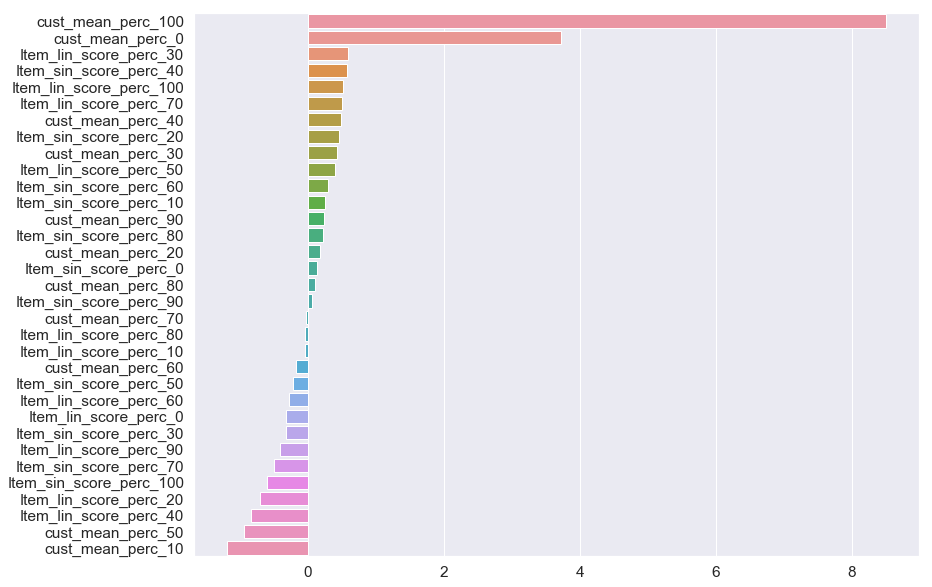

In [68]:


model = fit_model({}, x_train, x_test, y_train, y_test, weight_train=weight_train, weight_test=weight_test, modelname='logreg')
# model = fit_model({}, x_train, x_test, y_train, y_test, modelname='logreg')

fe = pd.Series(model.coef_[0], index=pred_columns)
# print ('\nFEATURE_IMPORTANCE: \n', fe)
plot_fe(fe)

In [69]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

train_precision, train_recall, train_thres = precision_recall_curve(y_train, train_pred)#, sample_weight=weight_train)
train_prc_auc = auc(train_recall, train_precision)

test_precision, test_recall, test_thres = precision_recall_curve(y_test, test_pred)#, sample_weight=weight_test)
test_prc_auc = auc(test_recall, test_precision)

print ('TRAIN ROC_AUC:', round(roc_auc_score(y_train, train_pred), 6), 'PRC_AUC:', round(train_prc_auc, 6), 'PRC_AUC_SCORE:', round(train_prc_auc_score, 6), 'ACCURACY:', round(accuracy_score(y_train, np.round(train_pred)), 6))
print ('TEST ROC_AUC:', round(roc_auc_score(y_test, test_pred), 6), 'PRC_AUC:', round(test_prc_auc, 6), 'PRC_AUC_SCORE:', round(test_prc_auc_score, 6), 'ACCURACY:', round(accuracy_score(y_test, np.round(test_pred)), 6))



TRAIN ROC_AUC: 0.685685 PRC_AUC: 0.889494 PRC_AUC_SCORE: 0.890784 ACCURACY: 0.701104
TEST ROC_AUC: 0.672902 PRC_AUC: 0.884557 PRC_AUC_SCORE: 0.847794 ACCURACY: 0.697605


In [70]:
train_pred = model.predict_proba(x_train).T[1]
test_pred = model.predict_proba(x_test).T[1]

train_precision, train_recall, train_thres = precision_recall_curve(y_train, train_pred, sample_weight=weight_train)
train_prc_auc = auc(train_recall, train_precision)

test_precision, test_recall, test_thres = precision_recall_curve(y_test, test_pred, sample_weight=weight_test)
test_prc_auc = auc(test_recall, test_precision)

print ('TRAIN ROC_AUC:', round(roc_auc_score(y_train, train_pred, sample_weight=weight_train), 6), 'PRC_AUC:', round(train_prc_auc, 6), 'PRC_AUC_SCORE:', round(train_prc_auc_score, 6), 'ACCURACY:', round(accuracy_score(y_train, np.round(train_pred), sample_weight=weight_train), 6))
print ('TEST ROC_AUC:', round(roc_auc_score(y_test, test_pred, sample_weight=weight_test), 6), 'PRC_AUC:', round(test_prc_auc, 6), 'PRC_AUC_SCORE:', round(test_prc_auc_score, 6), 'ACCURACY:', round(accuracy_score(y_test, np.round(test_pred), sample_weight=weight_test), 6))



C:\Python36\lib\site-packages\sklearn\metrics\ranking.py:526: RuntimeWarning: invalid value encountered in true_divide
  precision = tps / (tps + fps)


TRAIN ROC_AUC: 0.762978 PRC_AUC: 0.744492 PRC_AUC_SCORE: 0.890784 ACCURACY: 0.706801
TEST ROC_AUC: 0.748393 PRC_AUC: 0.744352 PRC_AUC_SCORE: 0.847794 ACCURACY: 0.688627


In [54]:
tmp['pred'] = np.round(model.predict_proba(tmp.loc[:, pred_columns].values).T[1], 6)
tmp['pred_label'] = model.predict(tmp.loc[:, pred_columns].values)

tmp.loc[tmp.sex != 0.5, 'pred_label'] = tmp.loc[tmp.sex != 0.5, 'sex'].values
tmp.pred_label.value_counts(normalize=True)

1.0    0.569648
0.0    0.430352
Name: pred_label, dtype: float64

## Использование предсказанных лейблов ЛогРег модели дает немного лучший результат по сравнению с LightGBM в Части 3.3. Поэтоме в дальнейшем будут использоваться предикты ЛогРег модели.

# Часть 3.3: Расчитаем updated_cust_mean (как и cast_mean в Части 2), только теперь для всех предсказанных лейблов.

In [61]:
for cl in ['pred', 'pred_label', 'updated_cust_mean']:
    if cl in purchases_train.columns:
        purchases_train.drop(cl, axis=1, inplace=True)
purchases_train = purchases_train.merge(tmp[['customer_id', 'pred', 'pred_label']], on='customer_id', how='left')

tmp1 = purchases_train.drop_duplicates(['customer_id', 'product_id']).reset_index(drop=True)#.groupby('product_id').agg({''})
tmp1['log_unique_prod_count'] = np.log(tmp1['unique_prod_count'].values + 1)
tmp1.loc[tmp1.sex != 0.5, 'log_unique_prod_count'] = tmp1['log_unique_prod_count'].max()
tmp1['tmp_feature'] = tmp1['log_unique_prod_count'].values * tmp1['pred_label'].values

temp = tmp1.groupby('product_id')[['tmp_feature', 'log_unique_prod_count']].sum().reset_index()
temp['updated_cust_mean'] = temp['tmp_feature'].values / temp['log_unique_prod_count'].values
tmp1 = tmp1.merge(temp[['product_id', 'updated_cust_mean']], on='product_id', how='left')

purchases_train = purchases_train.merge(tmp1[['product_id', 'customer_id', 'updated_cust_mean']], on=['product_id', 'customer_id'], how='left')

# #избавляемся от байеса для updated_cust_mean
median = purchases_train['updated_cust_mean'].median()
cond = (purchases_train['updated_cust_mean'] <= median)
purchases_train.loc[cond, 'updated_cust_mean'] = np.maximum(0, purchases_train.loc[cond, 'updated_cust_mean'].values/(2 *  median))
cond = (purchases_train['updated_cust_mean'] > median)
purchases_train.loc[cond, 'updated_cust_mean'] = np.minimum(1, 0.5 + (purchases_train.loc[cond, 'updated_cust_mean'].values -  median) /(2 * (1 -  median)))

tmp1 = purchases_train.drop_duplicates(['customer_id', 'product_id']).groupby('customer_id')['updated_cust_mean'].mean().reset_index()
if 'updated_cust_mean' in new_items_matrix.columns.values:
    new_users_matrix.drop('updated_cust_mean', axis=1, inplace=True)
new_users_matrix = new_users_matrix.merge(tmp1, on='customer_id', how='left')

tmp1 = purchases_train.groupby('product_id')['updated_cust_mean'].first().reset_index()
if 'updated_cust_mean' in new_items_matrix.columns.values:
    new_items_matrix.drop('updated_cust_mean', axis=1, inplace=True)
new_items_matrix = new_items_matrix.merge(tmp1, on='product_id', how='left')

In [62]:
purchases_train['updated_cust_mean'].median(), purchases_train['updated_cust_mean'].mean()

(0.5, 0.5190497861968205)

In [187]:
# new_users_matrix.to_csv('new_users_matrix.csv', sep=';')
# new_items_matrix.to_csv('new_items_matrix.csv', sep=';')

In [63]:
class Model():
    def __init__(self, user_matrix, item_matrix, cold_start_n, cold_start_func=1, rec_func=1):
        self.cold_start_n = cold_start_n
        self.user_matrix = user_matrix
        self.item_matrix = item_matrix
        
        if cold_start_func == 1:
            self.cold_start_func = self.rec_most_unique_pop
        elif cold_start_func == 2:
            self.cold_start_func = self.rec_most_pop
        elif cold_start_func == 3:
            self.cold_start_func = self.rec_most_unique_pop_last_month
        elif cold_start_func == 4:
            self.cold_start_func = self.rec_most_pop_last_month
            
        if rec_func == 1:
            self.rec_func = self.rec_cust_mean_prod_mean
        elif rec_func == 2:
            self.rec_func = self.rec_Item_sin_score_prod_mean
        elif rec_func == 3:
            self.rec_func = self.rec_Item_lin_score_prod_mean
        elif rec_func == 4:
            self.rec_func = self.rec_updated_cust_mean_prod_mean
        
    
    def rec_most_unique_pop_last_month(self, user): 
        # since for the cold-start problem we dont have enough information to get any prefernces about item - 
        # therefore we predict the most popular items despite sexual information
        tmp = self.item_matrix[~self.item_matrix.product_id.isin(user.product_ids)].sort_values('unique_cust_count_all_sex_last_month', ascending=False)
        return tmp[['product_id', 'unique_cust_count_all_sex_last_month']].values
    
    def rec_most_pop_last_month(self, user): 
        # since for the cold-start problem we dont have enough information to get any prefernces about item - 
        # therefore we predict the most popular items despite sexual information
        tmp = self.item_matrix[~self.item_matrix.product_id.isin(user.product_ids)].sort_values('cust_count_last_month', ascending=False)
        return tmp[['product_id', 'cust_count_last_month']].values
    
    def rec_most_unique_pop(self, user): 
        # since for the cold-start problem we dont have enough information to get any prefernces about item - 
        # therefore we predict the most popular items despite sexual information
        tmp = self.item_matrix[~self.item_matrix.product_id.isin(user.product_ids)].sort_values('unique_cust_count_all_sex', ascending=False)
        return tmp[['product_id', 'unique_cust_count_all_sex']].values
    
    def rec_most_pop(self, user): 
        # since for the cold-start problem we dont have enough information to get any prefernces about item - 
        # therefore we predict the most popular items despite sexual information
        tmp = self.item_matrix[~self.item_matrix.product_id.isin(user.product_ids)].sort_values('cust_count', ascending=False)
        return tmp[['product_id', 'cust_count']].values
        
    
    
    def rec_cust_mean_prod_mean(self, user):
        tmp = self.item_matrix[~self.item_matrix.product_id.isin(user.product_ids)].reset_index(drop=True)
        tmp['score'] = (1 - abs(tmp.cust_mean.values - user.cust_mean_prod_median)) * np.log(tmp.cust_count.values + 1)
        return tmp.sort_values('score', ascending=False)[['product_id', 'score']].values
    
    def rec_Item_sin_score_prod_mean(self, user):
        tmp = self.item_matrix[~self.item_matrix.product_id.isin(user.product_ids)].reset_index(drop=True)
        tmp['score'] = (10 - abs(tmp.Item_sin_score.values - user.Item_sin_score_prod_median)) * np.log(tmp.cust_count.values + 1)
        return tmp.sort_values('score', ascending=False)[['product_id', 'score']].values
    
    def rec_Item_lin_score_prod_mean(self, user):
        tmp = self.item_matrix[~self.item_matrix.product_id.isin(user.product_ids)].reset_index(drop=True)
        tmp['score'] = (10 - abs(tmp.Item_lin_score.values - user.Item_lin_score_prod_median)) * np.log(tmp.cust_count.values + 1)
        return tmp.sort_values('score', ascending=False)[['product_id', 'score']].values

    def rec_updated_cust_mean_prod_mean(self, user):
        tmp = self.item_matrix[~self.item_matrix.product_id.isin(user.product_ids)].reset_index(drop=True)
        tmp['score'] = (1 - abs(tmp.updated_cust_mean.values - user.updated_cust_mean)) * np.log(tmp.cust_count_last_month.values + 1)
        return tmp.sort_values('score', ascending=False)[['product_id', 'score']].values
        
    def recommend(self, user_id, k=10):
        try:
            user = self.user_matrix.loc[self.user_matrix.customer_id == user_id].iloc[0]
#             return self.cold_start_func(user)[:k].T
            if user.unique_prod_count <= self.cold_start_n: #cold_start
#                 print('cold')
                return self.cold_start_func(user)[:k].T
#                 return self.rec_most_unique_pop(user)[:10]
#                 return self.rec_most_pop(user)[:10]
            else:
#                 print('hot')
                return self.rec_func(user)[:k].T
#                 return self.rec_cust_mean_prod_mean(user)[:10]
#                 return self.rec_Item_sin_score_prod_mean(user)[:10]
#                 return self.rec_Item_lin_score_prod_mean(user)[:10]
        except Exception as e:
            print(e)
            user = self.user_matrix.loc[self.user_matrix.customer_id == user_id]
            print(user.shape)
            
            return None
#             tmp = self.item_matrix.sort_values('unique_cust_count_all_sex', ascending=False)
#             return tmp[['product_id', 'unique_cust_count_all_sex']].values
#             tmp = self.item_matrix.sort_values('unique_cust_count_all_sex', ascending=False)
#             return tmp[['product_id', 'cust_count']].values
            


In [64]:
for cold_st in [0, 1, 2, 3]:#, 4, 5, 6, 7, 8, 9, 10]:
    recommendations = []
    mdl = Model(new_users_matrix, new_items_matrix, cold_st, 3, 4)
    for ind, user_id in enumerate(relevant['customer_id'].values):
#         if ind%3000 == 0:
#             print(ind, relevant.shape[0])
        recommendations.append([x[0] for x in mdl.recommend(user_id)])
    print('cold_st:', cold_st, 'mapk', mapk(relevant['product_ids'], recommendations, k=10))

cold_st: 0 mapk 0.2138644166139767
cold_st: 1 mapk 0.20874523568292566
cold_st: 2 mapk 0.1827920548585242
cold_st: 3 mapk 0.1810323364134754


## Исходя из результатов наша модель теперь рекомендует лучше чем обычная, основанная на рекомендации наиболее популярных продуктов, согласно mapK метрике (исходя из увеличения N итоговое качество модели ухудшается).
# Baseline als модель на 64 (32) факторах дает 0.1041 (0.1538) mapK
# Лучшая cold_start модель дает около 0.18 mapK
# Последняя лучшая Feature-based модель дает около 0.2138 mapK